In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.CIFAR10('~/.pytorch/CIFAR10/', download=True, train=True, transform=transform)
training_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = datasets.CIFAR10('~/.pytorch/CIFAR10/', download=True, train=False, transform=transform)
validation_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)
# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(trainset)))
print('Validation set has {} instances'.format(len(testset)))

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


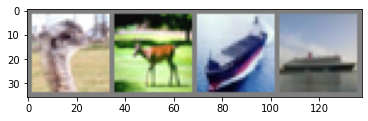

bird  deer  ship  ship 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(training_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
def my_cross_entropy(x, y):
    log_prob = -1.0 * F.log_softmax(x, 1)
    loss = log_prob.gather(1, y.unsqueeze(1))
    loss = loss.mean()
    return loss

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 7, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(7, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)
    
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = my_cross_entropy(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
EPOCHS = 4

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
        voutputs = model(vinputs)
        vloss = my_cross_entropy (voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2.2937175402641294
  batch 2000 loss: 2.105359245300293
  batch 3000 loss: 1.9095083329081535
  batch 4000 loss: 1.7981940550804139
  batch 5000 loss: 1.7144894353747369
  batch 6000 loss: 1.6326712791919709
  batch 7000 loss: 1.589599717527628
  batch 8000 loss: 1.5571669936478139
  batch 9000 loss: 1.5150812935233116
  batch 10000 loss: 1.473191980779171
  batch 11000 loss: 1.4786106426417827
  batch 12000 loss: 1.4188415480852128
LOSS train 1.4188415480852128 valid 1.4068570137023926
EPOCH 2:
  batch 1000 loss: 1.3782153843790292
  batch 2000 loss: 1.3710557547062636
  batch 3000 loss: 1.334727418333292
  batch 4000 loss: 1.34256518997252
  batch 5000 loss: 1.3284897524118424
  batch 6000 loss: 1.3087029652893543
  batch 7000 loss: 1.3182397070378065
  batch 8000 loss: 1.2810690077543259
  batch 9000 loss: 1.2811597477793693
  batch 10000 loss: 1.274080312371254
  batch 11000 loss: 1.2645016708448529
  batch 12000 loss: 1.2496491552814841
LOSS train 1.249

In [ ]:
def validate(testloader, model):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
validate(validation_loader, model)

Accuracy of the network on the 10000 test images: 61 %
